# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(———— #я не хочу его удалять, он угарный :)

H = round(-1*(0.8*np.log(0.8)+0.2*np.log(0.2)),2)

In [4]:
H

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [5]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

def entropy(l):
    pk=0.1*l
    return pk*(1-pk)
k1 = 8
k2 = 2
k=[k1, k2]
H=0
for i in k:
    pk=i/(k1+k2)
    H+=pk*(1-pk)
Q = round(H - abs(k1)/abs(k1+k2)*entropy(k1) - abs(k2)/abs(k1+k2)*entropy(k2),2)
Q

0.16

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [6]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

#каждая листовая вершина соответствует какой-то области признакового пространства
#прогноз в задаче регрессии - среднее правильных ответов в полученной вершине
y = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
cv = (1/len(y))*y.sum()
cv

40.6

## Часть: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

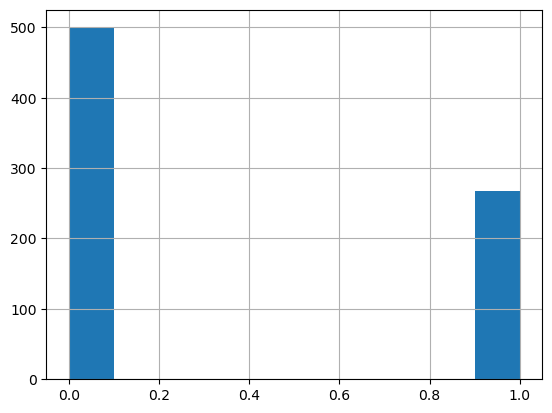

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.model_selection import train_test_split
X=data.drop(columns='Outcome')
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state = 123)
X_train_train, X_valid, y_train_train, y_valid = train_test_split(X_train,y_train, train_size=0.7, random_state = 123)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
import sklearn.metrics as sklm

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.metrics import f1_score
d = {}
depth_values = list(range(2, 10))
depth_values = sorted(depth_values)
depth_values.append(None)
min_samples_leaf_range = list(range(1,10))
for i in range(len(depth_values)):
    for j in range(len(sorted(min_samples_leaf_range))):
                   dt = DecisionTreeClassifier(max_depth = depth_values[i], min_samples_leaf=min_samples_leaf_range[j])
                   dt.fit(X_train_train, y_train_train)
                   f1 = f1_score(y_valid, dt.predict(X_valid))
                   d[f1] = [depth_values[i],min_samples_leaf_range[j]]
di = dict(sorted(d.items(), key = lambda x: x[0], reverse = True))
lis = list(di.items())[0][1]
print('Лучшая пара: \nглубина: {0}, количество листьев: {1}'.format(lis[0], lis[1]))
depth = lis[0]
leaves = lis[1]
dt = DecisionTreeClassifier(max_depth = depth, min_samples_leaf=leaves)
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
print('Accuracy: ', sklm.accuracy_score(y_test, pred))
print('Precision: ', sklm.precision_score(y_test, pred))
print('Recall: ', sklm.recall_score(y_test, pred))
print('AUC-ROC: ', sklm.roc_auc_score(y_test, pred))

Лучшая пара: 
глубина: 3, количество листьев: 9
Accuracy:  0.7229437229437229
Precision:  0.875
Recall:  0.3181818181818182
AUC-ROC:  0.6451048951048951


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
bg = BaggingClassifier()
bg.fit(X_train, y_train)
pred = bg.predict(X_test)
print('Accuracy: ', sklm.accuracy_score(y_test, pred))
print('Precision: ', sklm.precision_score(y_test, pred))
print('Recall: ', sklm.recall_score(y_test, pred))
print('AUC-ROC: ', sklm.roc_auc_score(y_test, pred))

Accuracy:  0.7359307359307359
Precision:  0.684931506849315
Recall:  0.5681818181818182
AUC-ROC:  0.7036713286713288


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.model_selection import cross_val_score
d = {}
depth_values = list(range(2, 10))
depth_values = sorted(depth_values)
depth_values.append(None)
min_samples_leaf_range = list(range(1,10))
for i in range(len(depth_values)):
    for j in range(len(sorted(min_samples_leaf_range))):
        rf = RandomForestClassifier(n_estimators = 50, max_depth = depth_values[i], min_samples_leaf=min_samples_leaf_range[j])
        f1 = cross_val_score(rf, X_train,y_train, scoring="f1", cv=30).mean()
        d[f1] = [depth_values[i], min_samples_leaf_range[j]]
di = dict(sorted(d.items(), key = lambda x: x[0], reverse = True))
lis = list(di.items())[0][1]
print('Лучшая пара: \nглубина: {0}, количество листьев: {1}'.format(lis[0], lis[1]))
depth = lis[0]
leaves = lis[1]
dt = DecisionTreeClassifier(max_depth = depth, min_samples_leaf=leaves)
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
print('Accuracy: ', sklm.accuracy_score(y_test, pred))
print('Precision: ', sklm.precision_score(y_test, pred))
print('Recall: ', sklm.recall_score(y_test, pred))
print('AUC-ROC: ', sklm.roc_auc_score(y_test, pred))

Лучшая пара: 
глубина: None, количество листьев: 2
Accuracy:  0.696969696969697
Precision:  0.6125
Recall:  0.5568181818181818
AUC-ROC:  0.6700174825174824


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

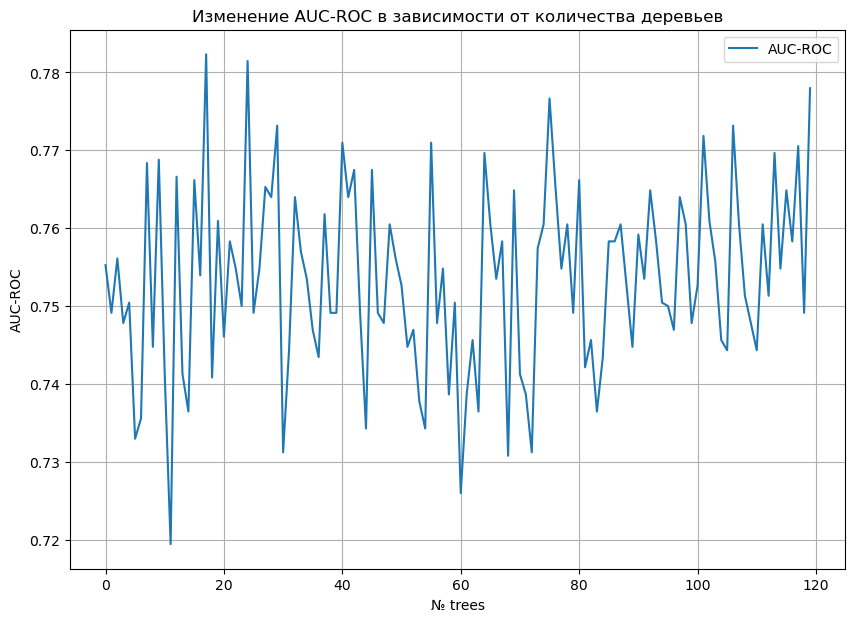

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————  взято с семинара: https://github.com/raYnii/Coursera_yandex_courses/blob/master/Bagging_and_random_forest.ipynb
auc_roc = []
trees = list(range(30,150))
for i in trees:
    rf = RandomForestClassifier(n_estimators = i)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    auc_roc.append(sklm.roc_auc_score(y_test, pred))

plt.figure(figsize=(10, 7))
plt.title("Изменение AUC-ROC в зависимости от количества деревьев")
plt.grid()
plt.plot(auc_roc, label="AUC-ROC")
plt.ylabel("AUC-ROC")
plt.xlabel("№ trees")
plt.legend();

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

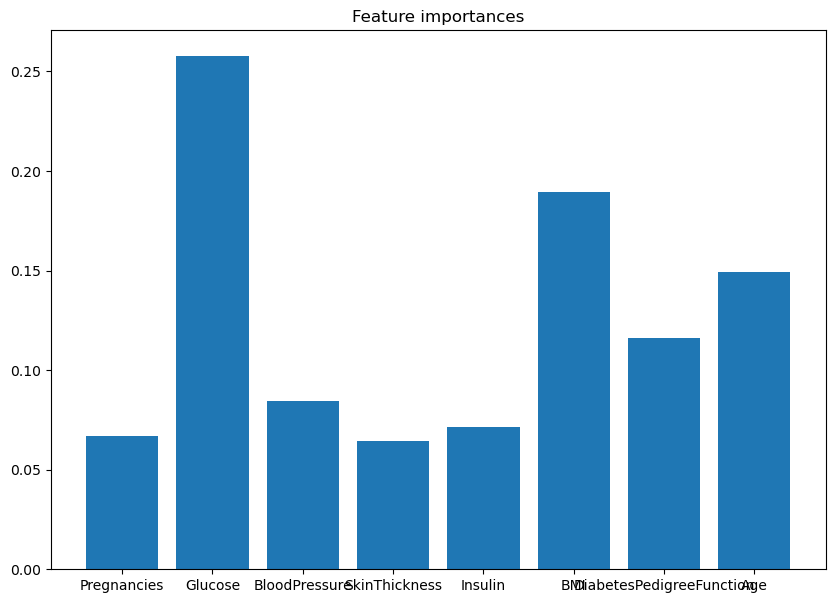

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
rf = RandomForestClassifier(n_estimators = 50, max_depth = depth, min_samples_leaf=leaves)
rf.fit(X_train, y_train)
plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(X_train.columns, rf.feature_importances_);